In [1]:
import numpy as np
import matplotlib.pyplot as plt

address = 'eq_until7'
Fe_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Fe.npz', allow_pickle=True)
Rh_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Rh.npz', allow_pickle=True)
Pt_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt.npz', allow_pickle=True)
train_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_train.npz', allow_pickle=True)
validate_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_validate.npz', allow_pickle=True)
test_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_test.npz', allow_pickle=True)


In [2]:
from cp2k_reader import Cp2kTrajHold, gather_all_data
from cp2k_reader import building_of_one_metal_traj, building_of_one_metal_special
from ocp.ocpmodels.datasets import SinglePointLmdbDataset

/Users/shaoketong/anaconda3/envs/new-ocp-models/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Fe_traj  = SinglePointLmdbDataset({"src": 'data/not_seen_Fe_all/not_seen_Fe_all.lmdb'})
Rh_traj  = SinglePointLmdbDataset({"src": 'data/not_seen_Rh_all/not_seen_Rh_all.lmdb'})
Pt_traj  = SinglePointLmdbDataset({"src": 'data/not_seen_Pt_all/not_seen_Pt_all.lmdb'})
test_true  = SinglePointLmdbDataset({"src": 'data/traj_all_test/traj_all_test.lmdb'})
validate_true  = SinglePointLmdbDataset({"src": 'data/traj_all_validate/traj_all_validate.lmdb'})
train_true  = SinglePointLmdbDataset({"src": 'data/traj_all_train/traj_all_train.lmdb'})
Pt_cluster  = SinglePointLmdbDataset({"src": 'data/Pt_cluster_all/Pt_cluster_all.lmdb'})
Ru_cluster  = SinglePointLmdbDataset({"src": 'data/Ru_cluster_all/Ru_cluster_all.lmdb'})


/Users/shaoketong/anaconda3/envs/new-ocp-models/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3548: UserWarning: SinglePointLmdbDataset is deprecated and will be removed in the future.Please use 'LmdbDataset' instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
from sklearn.metrics import r2_score, explained_variance_score

def energy_force_scores(true, pred, metal_number='all', score=r'$R^2$'):
    order = [int(_.split('_')[0]) for _ in pred['ids']]
    reverse_order = [0]*len(order)
    for idx, ord in enumerate(order):
        reverse_order[ord] = idx
    metal_y = [true[_].y for _ in range(len(true))]
    true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
    metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)
    if metal_number == 'all':
        true_metal_force = true_forces[metal_itself != 0, :].reshape(-1)
        pred_metal_force = pred['forces'][metal_itself != 0, :].reshape(-1)
    else:
        true_metal_force = true_forces[metal_itself == metal_number, :].reshape(-1)
        pred_metal_force = pred['forces'][metal_itself == metal_number, :].reshape(-1)
    if score == r'$R^2$':
        ene_score = r2_score(np.array(metal_y), pred['energy'][reverse_order])
        force_score = r2_score(true_metal_force, pred_metal_force)
    elif score == 'MAE':
        ene_score = np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean()
        force_score = np.abs(true_metal_force - pred_metal_force).mean()
    return ene_score, force_score
    

def plot_model_compare(files_list, labels, markers, score=r'$R^2$'):
    plt.rcParams['text.usetex'] = True
    params= {"text.latex.preamble": r"\usepackage{amsmath}"}
    plt.rcParams.update(params)
    fig, axs = plt.subplots(2, 2, dpi=400)
    #mycolor = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2',]
    #mycolor = ['#F27970', '#BB9727', '#54B345' , '#32B897', '#05B9E2', '#8983BF', '#C76DA2']
    #mycolor = ['#A1A9D0','#F0988C','#B883D4','#9E9E9E','#CFEAF1','#C4A5DE','#F6CAE5','#96CCCB']
    mycolor = [
                '#aec7e8',  # Light Blue
                '#ffbb78',  # Light Orange
                '#98df8a',  # Light Green
                '#ff9896',  # Light Red
                '#c5b0d5',  # Light Purple
                '#c49c94',  # Light Brown
                '#f7b6d2',  # Light Pink
                '#c7c7c7',  # Light Gray
                '#dbdb8d',  # Light Olive
                '#9edae5',  # Light Cyan
                '#fdd0a2',  # Light Peach
                '#d62728',  # Soft Red
                '#2ca02c',  # Soft Green
                '#7f7f7f',  # Medium Gray
                '#9467bd',  # Soft Purple
                '#8c564b',  # Soft Brown
                '#e377c2',  # Soft Pink
                '#bcbd22',  # Soft Lime
                '#17becf',  # Soft Cyan
                '#9c9ede'   # Lavender
            ]
    subplot_labels = ['(a) Test Data', '(b) Fe', '(c) Rh', '(d) Pt']

    for address, label, marker in zip(files_list, labels, markers):
        Fe_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Fe.npz', allow_pickle=True)
        Rh_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Rh.npz', allow_pickle=True)
        Pt_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_Pt.npz', allow_pickle=True)
        train_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_train.npz', allow_pickle=True)
        validate_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_validate.npz', allow_pickle=True)
        test_prediction = np.load(f'./results/final_res/{address}/s2ef_predictions_test.npz', allow_pickle=True)
        # test energy-force######
        ene_score, force_score = energy_force_scores(test_true, test_prediction, metal_number='all', score=score)
        axs[0,0].scatter(ene_score, force_score, s=12, marker=marker, label=label, color=mycolor[files_list.index(address)])
        # Fe energy-force######
        ene_score, force_score = energy_force_scores(Fe_traj, Fe_prediction, metal_number=26, score=score)
        axs[0,1].scatter(ene_score, force_score, s=12, marker=marker, label=label, color=mycolor[files_list.index(address)])
        # Rh energy-force######
        ene_score, force_score = energy_force_scores(Rh_traj, Rh_prediction, metal_number=45, score=score)
        axs[1,0].scatter(ene_score, force_score, s=12, marker=marker, label=label, color=mycolor[files_list.index(address)])
        # Pt energy-force######
        ene_score, force_score = energy_force_scores(Pt_traj, Pt_prediction, metal_number=78, score=score)
        axs[1,1].scatter(ene_score, force_score, s=12, marker=marker, label=label, color=mycolor[files_list.index(address)])

    axs[0,0].set(xlabel=f'Energy {score}', ylabel=f'Atomic Force {score}')
    axs[0,0].legend(ncol=2, frameon=False, loc='lower right', prop={'size': 6})
    axs[0,1].set(xlabel=f'Energy {score}', ylabel=f'Fe Atomic Force {score}')
    axs[1,0].set(xlabel=f'Energy {score}', ylabel=f'Rh Atomic Force {score}')
    axs[1,1].set(xlabel=f'Energy {score}', ylabel=f'Pt Atomic Force {score}')
    if score == r'$R^2$':
        axs[0,0].set_xlim([0.,1.05])
        axs[0,0].set_ylim([0.,1.05])
        axs[0,1].set_xlim([0.,1.05])
        axs[0,1].set_ylim([0.,1.05])
        axs[1,0].set_xlim([0.,1.05])
        axs[1,0].set_ylim([0.,1.05])
        axs[1,1].set_xlim([0.,1.05])
        axs[1,1].set_ylim([0.,1.05])
    #axs[0,1].legend(frameon=False, loc='lower right', prop={'size': 6})
    #axs[1,0].legend(frameon=False, loc='lower right', prop={'size': 6})
    #axs[1,1].legend(frameon=False, loc='lower right', prop={'size': 6})
    # Loop through all subplots and annotate them
    for ax_idx, ax in enumerate(axs.flat):
        # Place the annotation in the top-left corner of the subplot
        ax.text(0.02, 0.98, subplot_labels[ax_idx], transform=ax.transAxes, fontsize=12,
            verticalalignment='top')
    plt.tight_layout()
    plt.show()


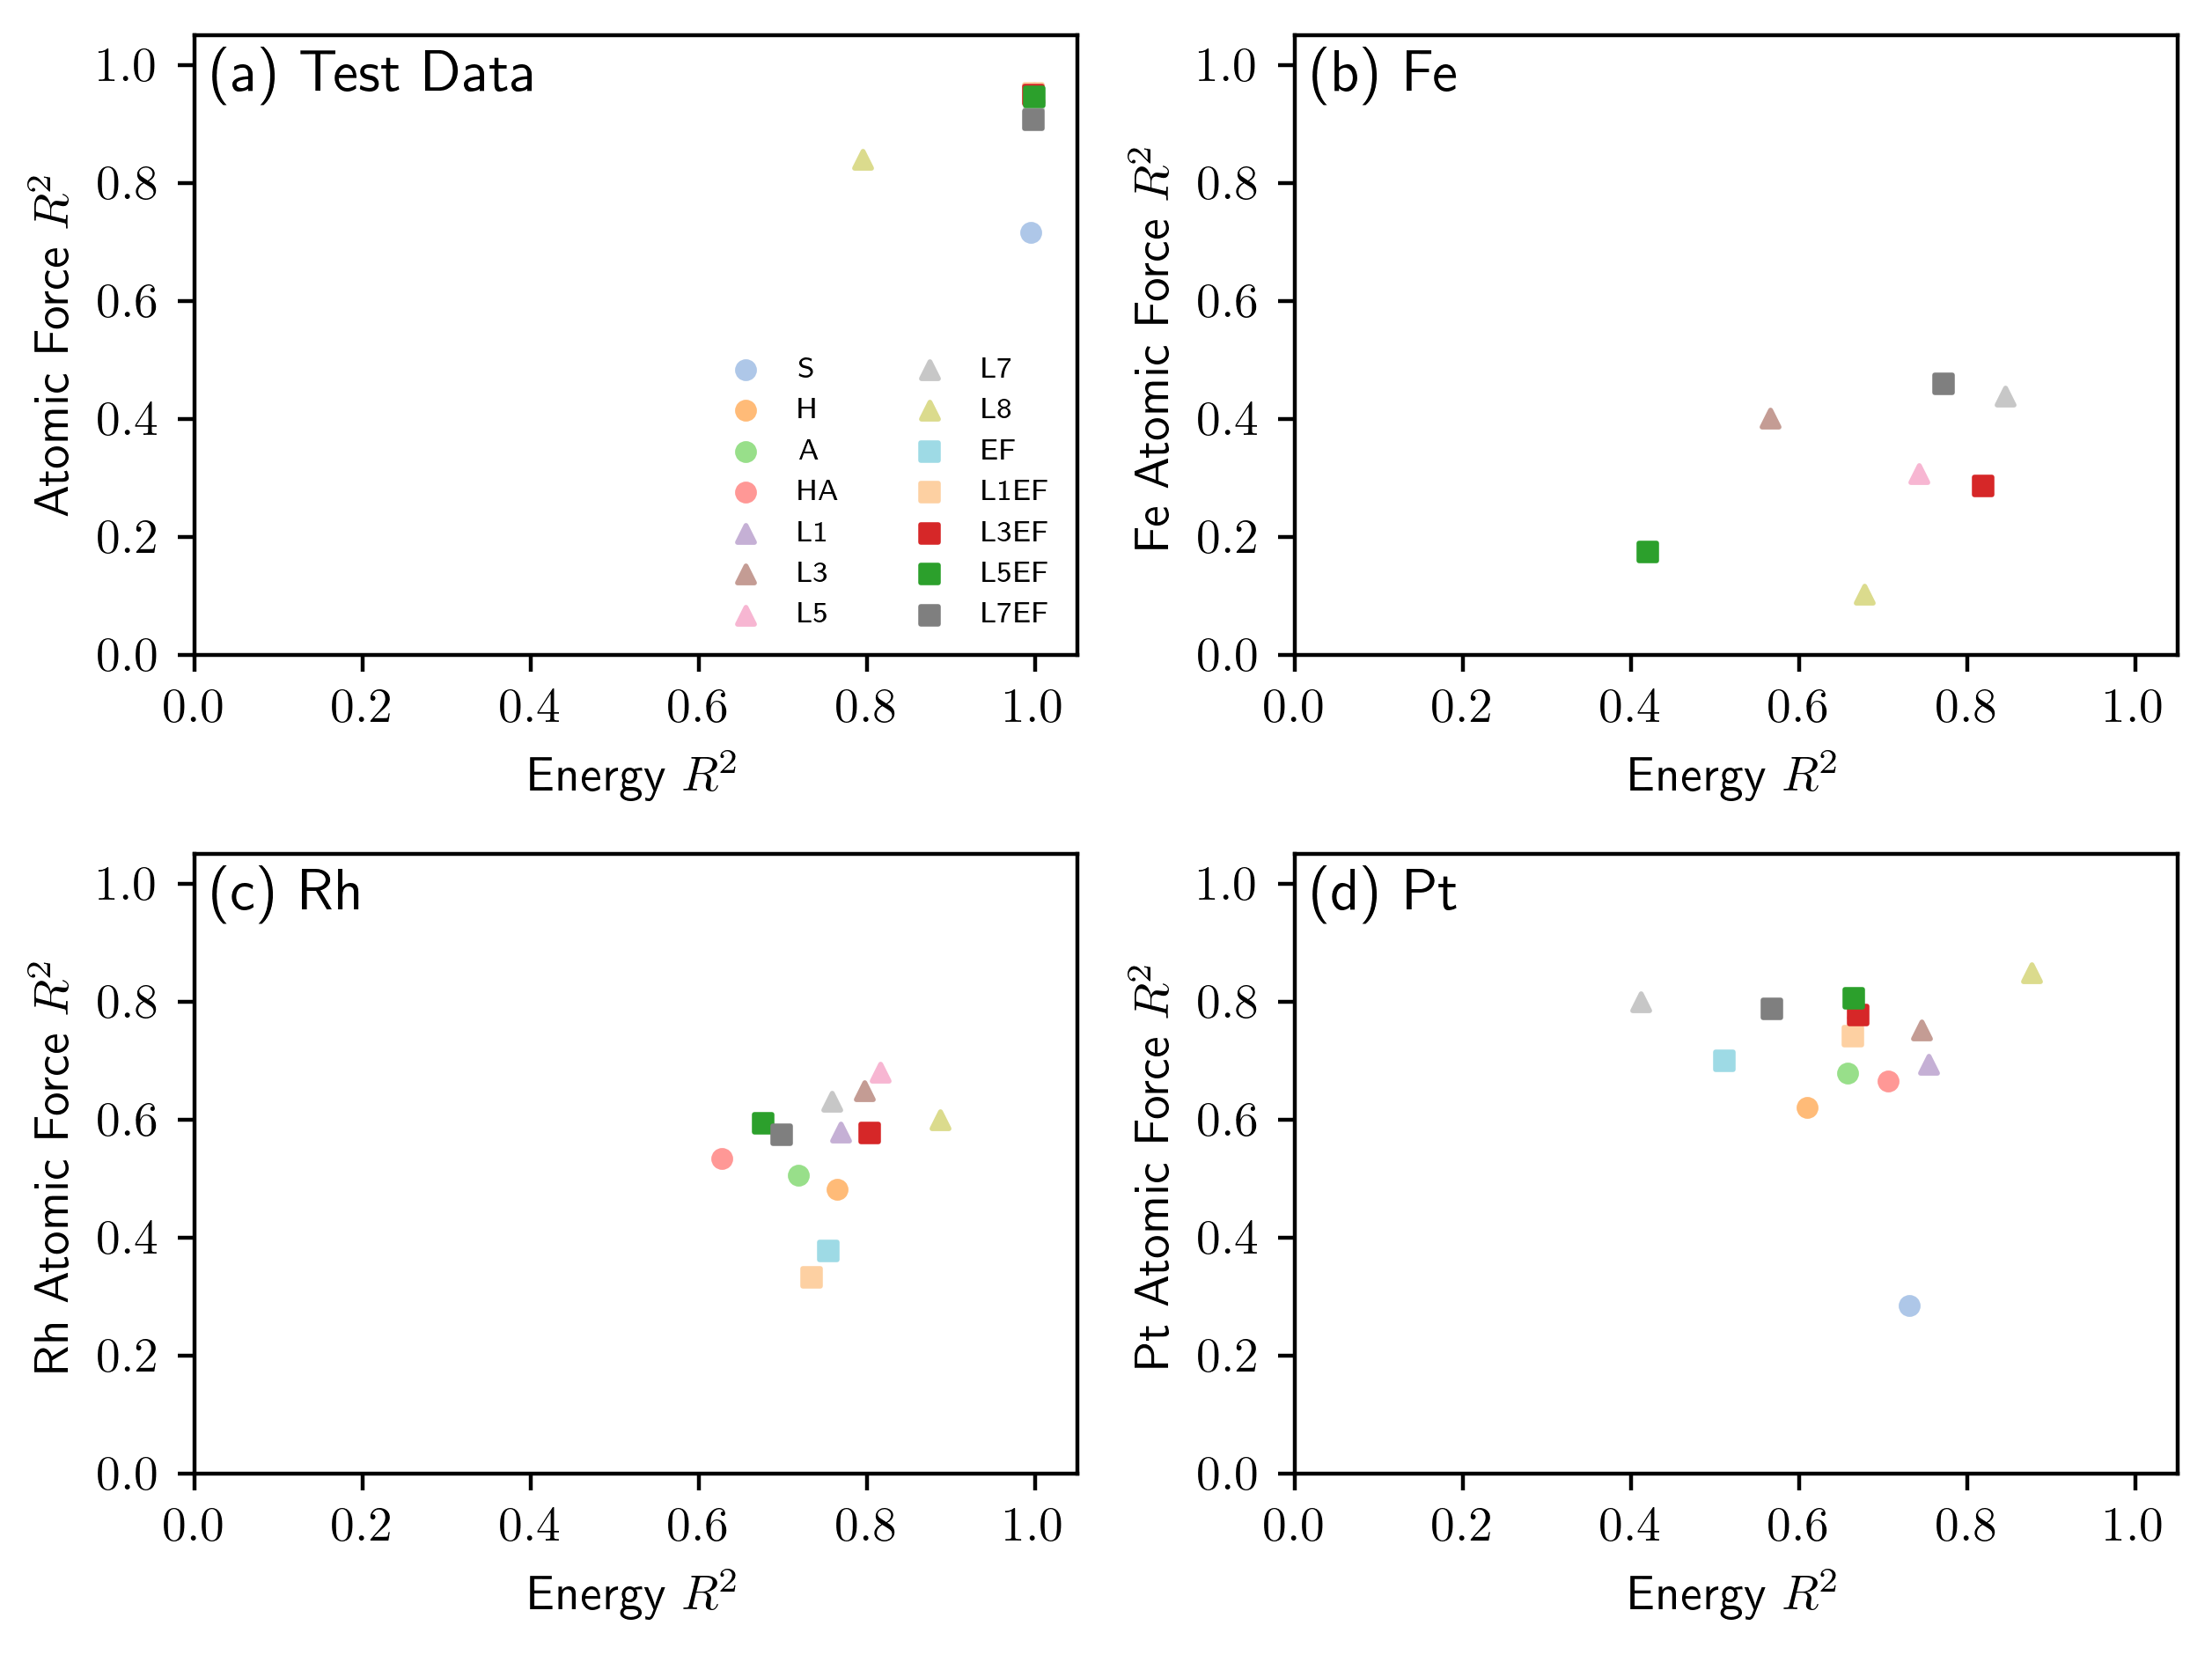

In [6]:
exps = ['eq_scratch', 'eq_allrelax', 'eq_relax_proton_random', 'eq_relax', 
        'eq_until1', 'eq_until3', 'eq_until5', 'eq_until7', 'eq_until8',
        'eq_relax_EFfix', 'eq_until1_EFfix', 'eq_until3_EFfix', 'eq_until5_EFfix', 'eq_until7_EFfix']
labels = [r'S', 
          r'H', 
          r'A', 
          r'HA',
          r'L1', 
          r'L3', 
          r'L5',
          r'L7', 
          r'L8', 
          r'EF',
          r'L1EF', 
          r'L3EF',  
          r'L5EF',
          r'L7EF', 
          ]
markers = ['o', 
           'o', 
           'o', 
           'o', 
          r'^', 
          r'^', 
          r'^',
          r'^', 
          r'^', 
          r's',
          r's', 
          r's',  
          r's',
          r's', 
          ]
plot_model_compare(exps, labels, markers, score=r'$R^2$')

In [20]:
from sklearn.metrics import r2_score, explained_variance_score
def plot_metal_parity_compare(true, pred_list, label_list, metal_number, ax1, ax2, 
                              plos_score=True, remove_outliers=False):
    mycolor = ['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2',]
    #mycolor = ['#F27970', '#BB9727', '#54B345' , '#32B897', '#05B9E2', '#8983BF', '#C76DA2']
    #mycolor = ['#A1A9D0','#F0988C','#B883D4','#9E9E9E','#CFEAF1','#C4A5DE','#F6CAE5','#96CCCB']
    ene_lim_max = float('-inf')
    ene_lim_min = float('inf')
    force_lim_max = float('-inf')
    force_lim_min = float('inf')
    for pred, label, color in zip(pred_list, label_list, mycolor):
        order = [int(_.split('_')[0]) for _ in pred['ids']]
        reverse_order = [0]*len(order)
        for idx, ord in enumerate(order):
            reverse_order[ord] = idx

        metal_y = [true[_].y for _ in range(len(true))]
        true_forces = np.vstack([true[_].force[true[_].fixed != 1,:] for _ in order])
        metal_itself = np.vstack([true[_].atomic_numbers[true[_].fixed != 1].reshape(-1,1) for _ in order]).reshape(-1)

    
        if plos_score:
            print(label)
            print('R2 ', r2_score(np.array(metal_y), pred['energy'][reverse_order]))
            print('MAE ', np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean())
            r2 = r2_score(np.array(metal_y), pred['energy'][reverse_order])
            mae = np.abs(np.array(metal_y)-pred['energy'][reverse_order]).mean()
            #ax1.annotate(f'R2: {r2:.4f}', xy=(0.05, 0.9), xycoords='axes fraction')
            #ax1.annotate(f'MAE: {mae:.4f}', xy=(0.05, 0.8), xycoords='axes fraction')
        
        ax1.scatter(np.array(metal_y), pred['energy'][reverse_order], s=7, label=label+f', $R^2$: {r2:.2f}', color=color)
            
        ene_lim_max = max(ene_lim_max, max(max(metal_y), max(pred['energy'][reverse_order]))*1.1)
        ene_lim_min = min(ene_lim_min, min(min(metal_y), min(pred['energy'][reverse_order]))*1.1)
        
        if metal_number == 'all':
            true_metal_force = true_forces[metal_itself != 0, :].reshape(-1)
            pred_metal_force = pred['forces'][metal_itself != 0, :].reshape(-1)
        else:
            true_metal_force = true_forces[metal_itself == metal_number, :].reshape(-1)
            pred_metal_force = pred['forces'][metal_itself == metal_number, :].reshape(-1)
        if remove_outliers:
            Q1 = np.percentile(true_metal_force, 25, method='midpoint')
            Q3 = np.percentile(true_metal_force, 75, method='midpoint')
            IQR = Q3 - Q1
            tmp_true = []
            tmp_pred = []
            multi = 5
            for _ in range(len(true_metal_force)):
                if Q1-multi*IQR<=true_metal_force[_]<=Q3+multi*IQR:
                    tmp_true.append(true_metal_force[_])
                    tmp_pred.append(pred_metal_force[_])
            true_metal_force, pred_metal_force = np.array(tmp_true), np.array(tmp_pred)

        if plos_score:
            print('R2 ', r2_score(true_metal_force, pred_metal_force))
            print('MAE ', np.abs(true_metal_force - pred_metal_force).mean())
            #ax2.annotate(f'R2: {r2_score(true_metal_force, pred_metal_force):.4f}', xy=(0.05, 0.9), xycoords='axes fraction')
            #ax2.annotate(f'MAE: {np.abs(true_metal_force - pred_metal_force).mean():.4f}', xy=(0.05, 0.8), xycoords='axes fraction')
        ax2.scatter(true_metal_force, pred_metal_force, s=7, color=color, label=label+f', $R^2$: {r2_score(true_metal_force, pred_metal_force):.2f}')
        
        force_lim_max = max(force_lim_max, max(max(true_metal_force), max(pred_metal_force))*1.1)
        force_lim_min = min(force_lim_min, min(min(true_metal_force), min(pred_metal_force))*1.1)
    ax1.set(xlabel='True', ylabel='Pred')
    ax2.set(xlabel='True', ylabel='Pred')
    ax1.plot([ene_lim_min, ene_lim_max], [ene_lim_min, ene_lim_max], ls="--", c=".3")
    ax1.set_xlim([ene_lim_min, ene_lim_max])
    ax1.set_ylim([ene_lim_min, ene_lim_max])
    ax1.legend(frameon=False, loc='lower right', prop={'size': 9})
    
    ax2.plot([force_lim_min-1, force_lim_max+1], [force_lim_min-1, force_lim_max+1], ls="--", c=".3")
    ax2.set_xlim([force_lim_min, force_lim_max])
    ax2.set_ylim([force_lim_min, force_lim_max])
    ax2.legend(frameon=False, loc='lower right', prop={'size': 9})

    

In [ ]:
Fe_prediction_list = []
Rh_prediction_list = []
Pt_prediction_list = []
train_prediction_list = []
validate_prediction_list = []
test_prediction_list = []
names = ['eq_scratch', 'eq_until7']
for address in names:
    Fe_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Fe.npz', allow_pickle=True))
    Rh_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Rh.npz', allow_pickle=True))
    Pt_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_Pt.npz', allow_pickle=True))
    train_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_train.npz', allow_pickle=True))
    validate_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_validate.npz', allow_pickle=True))
    test_prediction_list.append(np.load(f'./results/final_res/{address}/s2ef_predictions_test.npz', allow_pickle=True))

S
R2  0.7901349789324302
MAE  0.5109410427143063
R2  -9.20430413489451
MAE  0.26493484
L7
R2  0.8451399110535867
MAE  0.44963464545785087
R2  0.43792120902257003
MAE  0.065678746
S
R2  0.46698388474515695
MAE  0.8623159393430773
R2  -1.3174546046812226
MAE  0.14407873
L7
R2  0.7585049619584591
MAE  0.5227294467542695
R2  0.6314863574027039
MAE  0.07675386
S
R2  0.7308687504607937
MAE  0.5802816570120463
R2  0.2845679803736343
MAE  0.13566087
L7
R2  0.4118127767274471
MAE  0.8505104499144516
R2  0.799586149748442
MAE  0.086805835


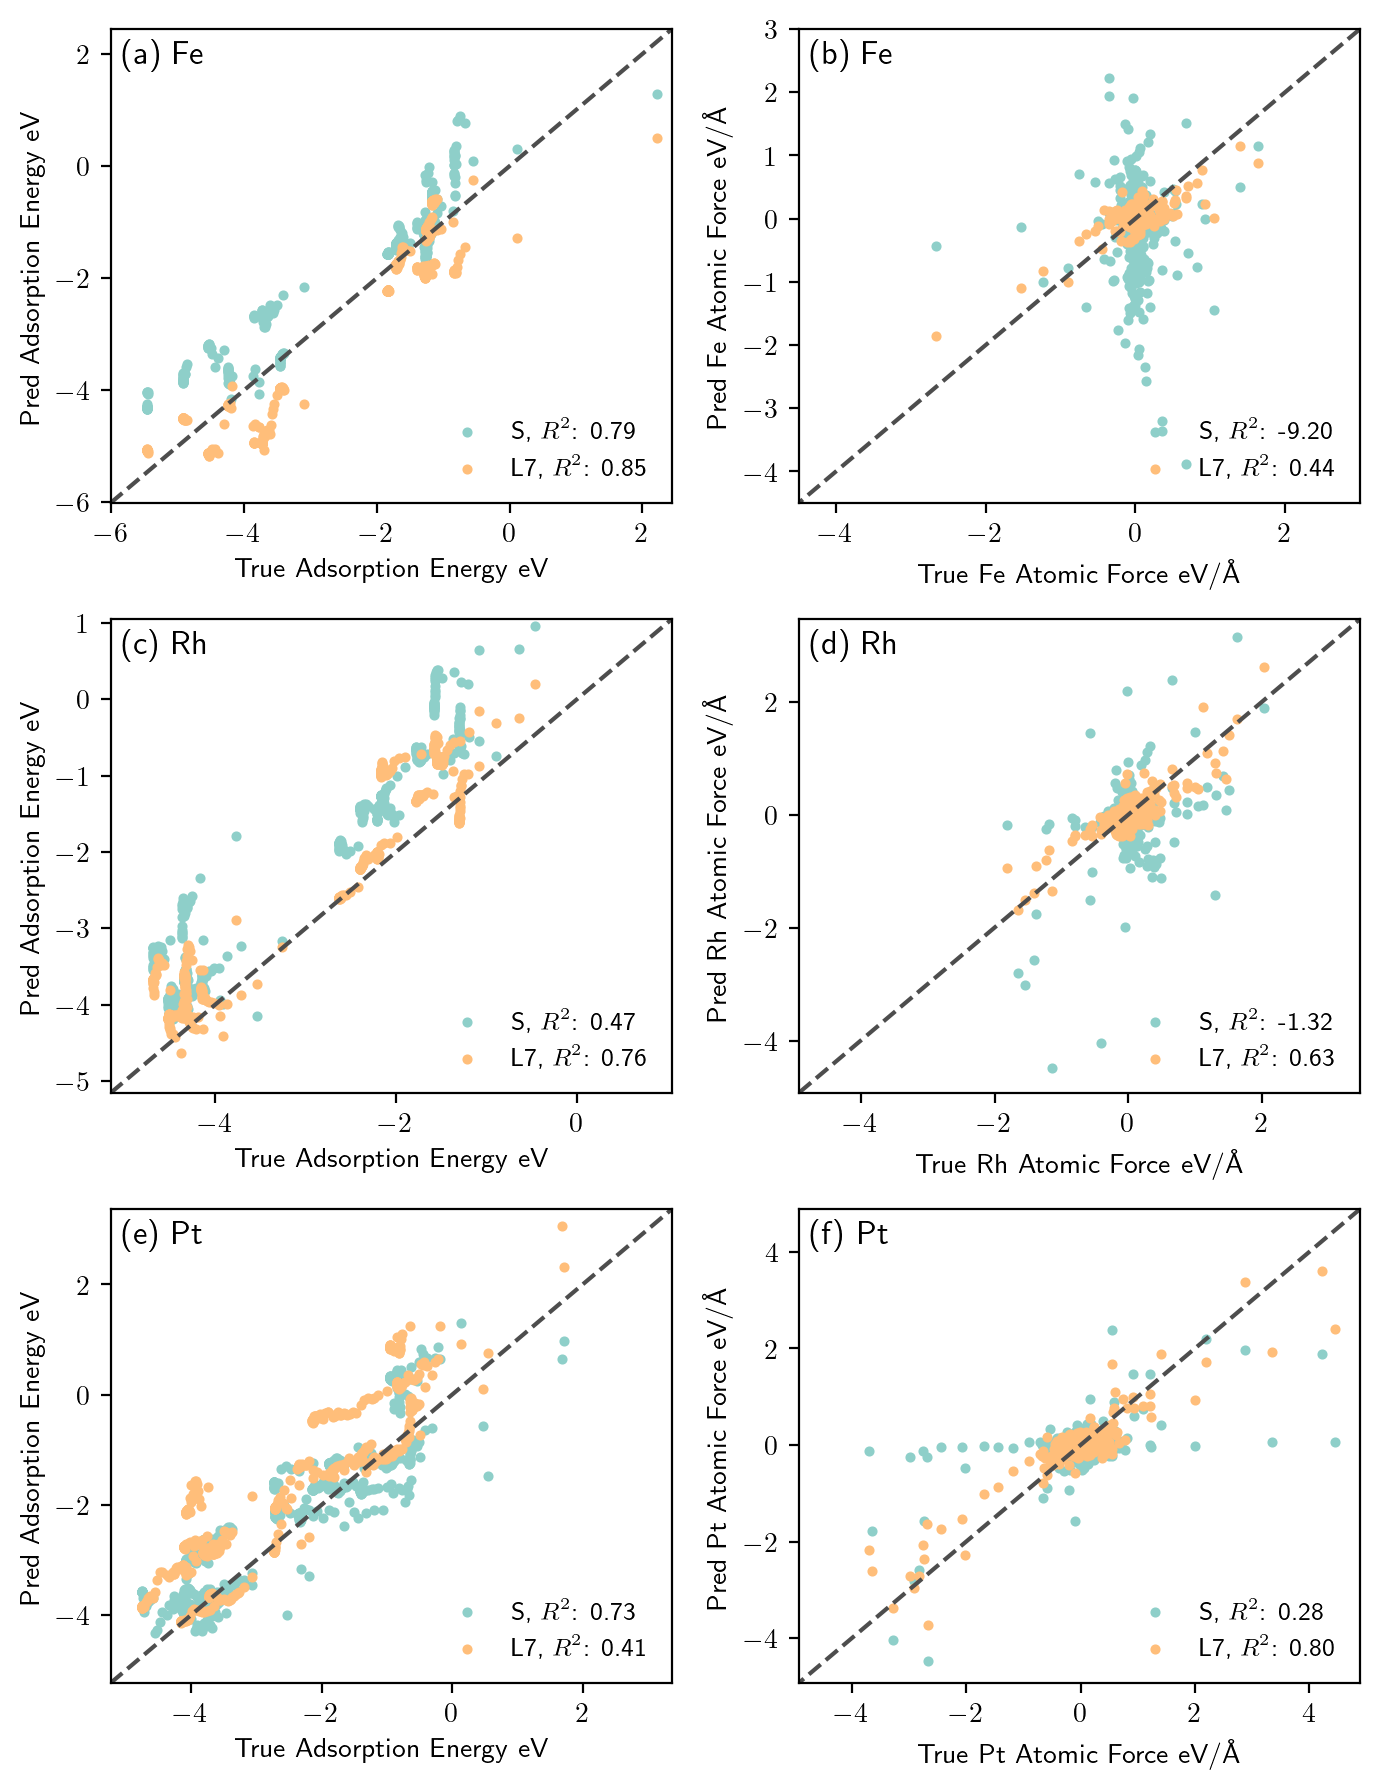

In [21]:
siguations = [r'S', r'L7']
fig, axs = plt.subplots(3, 2, dpi=200, figsize=(7,3*3))
plot_metal_parity_compare(Fe_traj, Fe_prediction_list, siguations, 26, axs[0,0], axs[0,1], True)
plot_metal_parity_compare(Rh_traj, Rh_prediction_list, siguations, 45, axs[1,0], axs[1,1], True)
plot_metal_parity_compare(Pt_traj, Pt_prediction_list, siguations, 78, axs[2,0], axs[2,1], True)
axs[0,0].set(xlabel='True Adsorption Energy eV', ylabel='Pred Adsorption Energy eV')
axs[0,1].set(xlabel='True Fe Atomic Force eV/Å', ylabel='Pred Fe Atomic Force eV/Å')
axs[1,0].set(xlabel='True Adsorption Energy eV', ylabel='Pred Adsorption Energy eV')
axs[1,1].set(xlabel='True Rh Atomic Force eV/Å', ylabel='Pred Rh Atomic Force eV/Å')
axs[2,0].set(xlabel='True Adsorption Energy eV', ylabel='Pred Adsorption Energy eV')
axs[2,1].set(xlabel='True Pt Atomic Force eV/Å', ylabel='Pred Pt Atomic Force eV/Å')
subplot_labels = ['(a) Fe', '(b) Fe', '(c) Rh', '(d) Rh', '(e) Pt', '(f) Pt']
for ax_idx, ax in enumerate(axs.flat):
    # Place the annotation in the top-left corner of the subplot
    ax.text(0.02, 0.98, subplot_labels[ax_idx], transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
axs[0,1].set_xlim([-4.5, 3])
axs[0,1].set_ylim([-4.5, 3])
plt.tight_layout()
plt.show()